In [2]:
# 전처리
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#평가 및 파라미터 튜닝
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
#학습모델 저장
import pickle
from sklearn.externals import joblib
#인공지능 모델
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 전처리

In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


In [4]:
df[['name', 'currency', 'main_category', 'sub_category', 'duration', 'goal_usd', 'status', 'start_Q', 'end_Q']]

,name,currency,main_category,sub_category,duration,goal_usd,status,start_Q,end_Q
0,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,16.0,2000.00000,successful,Q4,Q4
1,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,30.0,3870.99771,successful,Q3,Q3
2,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,30.0,1100.00000,successful,Q2,Q3
3,Lost Dog Street Band's Next Album,USD,music,Country & Folk,45.0,3500.00000,successful,Q3,Q4
4,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,60.0,30000.00000,successful,Q4,Q1
...,...,...,...,...,...,...,...,...,...
192543,Book CafÃÂ© Bergen,NOK,food,Drinks,60.0,57858.66500,failed,Q4,Q4
192544,Chainlink tool,NOK,technology,Fabrication Tools,47.0,115717.33000,failed,Q4,Q4
192545,PNW Juice Truck,USD,food,Drinks,30.0,30000.00000,failed,Q1,Q1
192546,succulent christmas tree,USD,art,Conceptual Art,60.0,1200.00000,failed,Q3,Q4


In [5]:
df[['duration', 'goal_usd']].describe().loc[['mean', 'min', 'max']] # 데이터 범위 파악

,duration,goal_usd
mean,32.362907,3.704990e+04
min,1.000000,1.000000e-02
max,93.000000,1.290333e+08


In [6]:
df[df['main_category'] == 'crafts']['sub_category'].value_counts()

Woodworking    1540
DIY            1376
Crafts         1226
Candles         513
Stationery      337
Knitting        298
Printing        282
Crochet         208
Pottery         184
Glass           177
Embroidery      145
Weaving         127
Quilts          102
Taxidermy        15
Name: sub_category, dtype: int64

In [7]:
label = df['status']
df = df[['currency','main_category', 'sub_category',
     'duration', 'goal_usd', 'usd_pledged', 'start_Q', 'end_Q']]# data, target 분리

df['Q_concat'] = df['start_Q'].str[-1] + df['end_Q'].str[-1]
df.drop(['start_Q', 'end_Q'], inplace = True, axis = 1)# 쿼터 기간별 새로운 피쳐 생성 (start_Q, end_Q 통합)
df.drop(['usd_pledged'], inplace = True ,axis = 1) #학습에 지장을 줄 수 있는 피쳐 제거
df.head()

,currency,main_category,sub_category,duration,goal_usd,Q_concat
0,USD,games,Tabletop Games,16.0,2000.00000,44
1,GBP,comics,Comic Books,30.0,3870.99771,33
2,USD,fashion,Apparel,30.0,1100.00000,23
3,USD,music,Country & Folk,45.0,3500.00000,34
4,USD,technology,Gadgets,60.0,30000.00000,41


In [8]:
scaler = StandardScaler()
scaler.fit(df[['duration', 'goal_usd']])
df_scaled_part = scaler.transform(df[['duration', 'goal_usd']]) # 범위와 단위가 상이한 duration, goal_usd 피쳐에 대해 standard scaling
df_scaled_part = pd.DataFrame(df_scaled_part, columns = ['duration', 'goal_usd'])
df['duration'] = df_scaled_part['duration']
df['goal_usd'] = df_scaled_part['goal_usd']
df.head()

,currency,main_category,sub_category,duration,goal_usd,Q_concat
0,USD,games,Tabletop Games,-1.409343,-0.033824,44
1,GBP,comics,Comic Books,-0.203518,-0.032019,33
2,USD,fashion,Apparel,-0.203518,-0.034693,23
3,USD,music,Country & Folk,1.088437,-0.032377,34
4,USD,technology,Gadgets,2.380393,-0.006803,41


In [9]:
en = LabelEncoder()
en.fit(label)
label = en.transform(label) # target data에 대해 label encoding
label

array([1, 1, 1, ..., 0, 0, 0])

## sub_category 이상치 제거

In [10]:
# main_category 개수 10000개 이상일 경우 300개 이하 sub_category 데이터는 이상치로 판단, 10000개 이하일 경우 100개 이하 데이터 이상치로 판단
df.loc[df['sub_category'] == 'Bacon', 'sub_category'] = 'Food'
df.loc[(df['sub_category'] == 'Puzzles'), 'sub_category'] = 'Games'
df.loc[(df['sub_category'] == 'Pet Fashion'), 'sub_category'] = 'Fashion'
df.loc[(df['sub_category'] == 'Couture'), 'sub_category'] = 'Fashion'

df.loc[(df['sub_category'] == 'Blues'),  'sub_category'] = 'Music'
df.loc[df['sub_category'] == 'Latin', 'sub_category'] = 'Music'
df.loc[df['sub_category'] == 'Comedy', 'sub_category'] = 'Music'
df.loc[df['sub_category'] == 'Chiptune', 'sub_category'] = 'Music'

# film & video 카테고리 전처리
df.loc[(df['sub_category'] == 'Romance'),  'sub_category'] = 'Film & Video'

# technology 카테고리 전처리
df.loc[(df['sub_category'] == 'Fabrication Tools'),  'sub_category'] = 'Technology'
df.loc[df['sub_category'] == 'Makerspaces', 'sub_category'] = 'Technology'

# art 카테고리 전처리
df.loc[(df['sub_category'] == 'Video Art'),  'sub_category'] = 'Art'

# publishing 카테고리 전처리
df.loc[(df['sub_category'] == 'Translations'),  'sub_category'] = 'Publishing'
df.loc[df['sub_category'] == 'Comedy', 'sub_category'] = 'Publishing'
df.loc[df['sub_category'] == 'Literary Spaces', 'sub_category'] = 'Publishing'
df.loc[df['sub_category'] == 'Letterpress', 'sub_category'] = 'Publishing'

df.loc[df['sub_category']=='Taxidermy','sub_category']='Crafts'

## 데이터 셋 후보

### 1. only label encoding
### 2. label encoding + without sub_cat
### 3. one_hot_encoding
### 4. one_hot_encoding + without sub_cat

## 학습 모델 후보

### 1. Random Forest
### 2. Lightgbm
### 3. Decsion Tree

In [11]:
objs = ['main_category', 'sub_category','currency', 'Q_concat'] # 카테고리컬한 피쳐에 대해 라벨 인코딩
df_label = df
for obj in objs:
    en.fit(df[obj])
    df_label[obj] = en.transform(df[obj])
df_label.head() # 1. only label encoding

,currency,main_category,sub_category,duration,goal_usd,Q_concat
0,13,8,123,-1.409343,-0.033824,7
1,5,1,21,-0.203518,-0.032019,4
2,13,5,7,-0.203518,-0.034693,3
3,13,10,26,1.088437,-0.032377,5
4,13,13,55,2.380393,-0.006803,6


In [12]:
df_label_without_sub = df_label.drop(['sub_category'], axis = 1)
df_label_without_sub.head() # 2. label + without sub

,currency,main_category,duration,goal_usd,Q_concat
0,13,8,-1.409343,-0.033824,7
1,5,1,-0.203518,-0.032019,4
2,13,5,-0.203518,-0.034693,3
3,13,10,1.088437,-0.032377,5
4,13,13,2.380393,-0.006803,6


In [13]:
df_oh = pd.get_dummies(df, columns = ['currency', 'main_category', 'sub_category', 'Q_concat'])
df_oh.head() # 3. one_hot_encoding

,duration,goal_usd,currency_0,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,...,sub_category_141,sub_category_142,Q_concat_0,Q_concat_1,Q_concat_2,Q_concat_3,Q_concat_4,Q_concat_5,Q_concat_6,Q_concat_7
0,-1.409343,-0.033824,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.203518,-0.032019,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.203518,-0.034693,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.088437,-0.032377,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2.380393,-0.006803,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
df_oh_without_sub = pd.get_dummies(df_label_without_sub, columns = ['currency', 'main_category', 'Q_concat'])
df_oh_without_sub.head()


,duration,goal_usd,currency_0,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,...,main_category_13,main_category_14,Q_concat_0,Q_concat_1,Q_concat_2,Q_concat_3,Q_concat_4,Q_concat_5,Q_concat_6,Q_concat_7
0,-1.409343,-0.033824,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.203518,-0.032019,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.203518,-0.034693,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.088437,-0.032377,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2.380393,-0.006803,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


# 학습모델 객체 생성

In [15]:
rand_clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1) # RandomForest
dtree_clf = DecisionTreeClassifier() # DecisionTree
lgbm_wrapper = LGBMClassifier(n_estimators = 400, boost_from_average = False) # LightGBM

# 학습, 평가 함수

In [19]:
def fit_and_accuracy_comp(x_train, y_train, x_test, y_test):
    evals = [(x_test, y_test)] # 평가 데이터셋 for LightGBM
    
    # 학습
    rand_clf.fit(x_train, y_train)
    dtree_clf.fit(x_train, y_train)
    lgbm_wrapper.fit(x_train, y_train, early_stopping_rounds = 200, eval_metric = 'logloss', 
                eval_set = evals, verbose = True)
    
    # 예측
    pred_rand = rand_clf.predict(x_test)
    pred_dtree = dtree_clf.predict(x_test)
    pred_lgbm = lgbm_wrapper.predict(x_test)
    
    # 에측 정확도 출력 (평가 지표 : 정확도(accuracy))
    print("RandomForest : ", accuracy_score(pred_rand, y_test))
    print("Decision Tree : ", accuracy_score(pred_dtree, y_test))
    print("LightGBM : ", accuracy_score(pred_lgbm, y_test))

## 1-1-1 train-test 분리

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df_label, label, stratify = label, test_size = 0.2)

## 1-1-2 학습

In [21]:
fit_and_accuracy_comp(x_train, y_train, x_test, y_test)

[1]	valid_0's binary_logloss: 0.675538
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.660928
[3]	valid_0's binary_logloss: 0.64942
[4]	valid_0's binary_logloss: 0.637832
[5]	valid_0's binary_logloss: 0.627109
[6]	valid_0's binary_logloss: 0.6153
[7]	valid_0's binary_logloss: 0.607809
[8]	valid_0's binary_logloss: 0.598309
[9]	valid_0's binary_logloss: 0.591336
[10]	valid_0's binary_logloss: 0.58407
[11]	valid_0's binary_logloss: 0.578451
[12]	valid_0's binary_logloss: 0.571944
[13]	valid_0's binary_logloss: 0.568295
[14]	valid_0's binary_logloss: 0.562069
[15]	valid_0's binary_logloss: 0.556319
[16]	valid_0's binary_logloss: 0.552626
[17]	valid_0's binary_logloss: 0.548367
[18]	valid_0's binary_logloss: 0.545533
[19]	valid_0's binary_logloss: 0.541191
[20]	valid_0's binary_logloss: 0.538757
[21]	valid_0's binary_logloss: 0.535932
[22]	valid_0's binary_logloss: 0.530402
[23]	valid_0's binary_logloss: 0.528942
[24]	valid_0's binary_logloss: 

[206]	valid_0's binary_logloss: 0.441136
[207]	valid_0's binary_logloss: 0.441129
[208]	valid_0's binary_logloss: 0.441069
[209]	valid_0's binary_logloss: 0.441074
[210]	valid_0's binary_logloss: 0.441049
[211]	valid_0's binary_logloss: 0.441045
[212]	valid_0's binary_logloss: 0.441001
[213]	valid_0's binary_logloss: 0.44097
[214]	valid_0's binary_logloss: 0.440936
[215]	valid_0's binary_logloss: 0.44091
[216]	valid_0's binary_logloss: 0.440749
[217]	valid_0's binary_logloss: 0.440757
[218]	valid_0's binary_logloss: 0.440694
[219]	valid_0's binary_logloss: 0.440654
[220]	valid_0's binary_logloss: 0.440635
[221]	valid_0's binary_logloss: 0.440646
[222]	valid_0's binary_logloss: 0.440625
[223]	valid_0's binary_logloss: 0.440581
[224]	valid_0's binary_logloss: 0.44055
[225]	valid_0's binary_logloss: 0.440545
[226]	valid_0's binary_logloss: 0.440493
[227]	valid_0's binary_logloss: 0.440498
[228]	valid_0's binary_logloss: 0.4405
[229]	valid_0's binary_logloss: 0.44041
[230]	valid_0's binary

## 1-2-1

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df_label_without_sub, label, stratify = label, test_size = 0.2)

## 1-2-2

In [23]:
fit_and_accuracy_comp(x_train, y_train, x_test, y_test)

[1]	valid_0's binary_logloss: 0.678038
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.665539
[3]	valid_0's binary_logloss: 0.654828
[4]	valid_0's binary_logloss: 0.646229
[5]	valid_0's binary_logloss: 0.63828
[6]	valid_0's binary_logloss: 0.631893
[7]	valid_0's binary_logloss: 0.626504
[8]	valid_0's binary_logloss: 0.621911
[9]	valid_0's binary_logloss: 0.617594
[10]	valid_0's binary_logloss: 0.614297
[11]	valid_0's binary_logloss: 0.611558
[12]	valid_0's binary_logloss: 0.608899
[13]	valid_0's binary_logloss: 0.606121
[14]	valid_0's binary_logloss: 0.603599
[15]	valid_0's binary_logloss: 0.600893
[16]	valid_0's binary_logloss: 0.598875
[17]	valid_0's binary_logloss: 0.597533
[18]	valid_0's binary_logloss: 0.596411
[19]	valid_0's binary_logloss: 0.59434
[20]	valid_0's binary_logloss: 0.592998
[21]	valid_0's binary_logloss: 0.591415
[22]	valid_0's binary_logloss: 0.590461
[23]	valid_0's binary_logloss: 0.589464
[24]	valid_0's binary_logloss

[214]	valid_0's binary_logloss: 0.571183
[215]	valid_0's binary_logloss: 0.571171
[216]	valid_0's binary_logloss: 0.571168
[217]	valid_0's binary_logloss: 0.571123
[218]	valid_0's binary_logloss: 0.571135
[219]	valid_0's binary_logloss: 0.571126
[220]	valid_0's binary_logloss: 0.571092
[221]	valid_0's binary_logloss: 0.571093
[222]	valid_0's binary_logloss: 0.571076
[223]	valid_0's binary_logloss: 0.571087
[224]	valid_0's binary_logloss: 0.571048
[225]	valid_0's binary_logloss: 0.571024
[226]	valid_0's binary_logloss: 0.571015
[227]	valid_0's binary_logloss: 0.571013
[228]	valid_0's binary_logloss: 0.570968
[229]	valid_0's binary_logloss: 0.57096
[230]	valid_0's binary_logloss: 0.570962
[231]	valid_0's binary_logloss: 0.570948
[232]	valid_0's binary_logloss: 0.570939
[233]	valid_0's binary_logloss: 0.570947
[234]	valid_0's binary_logloss: 0.570928
[235]	valid_0's binary_logloss: 0.570937
[236]	valid_0's binary_logloss: 0.570945
[237]	valid_0's binary_logloss: 0.570938
[238]	valid_0's b

## 1-3-1

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df_oh, label, stratify = label, test_size = 0.2)

## 1-3-2

In [25]:
fit_and_accuracy_comp(x_train, y_train, x_test, y_test)

[1]	valid_0's binary_logloss: 0.668345
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.64779
[3]	valid_0's binary_logloss: 0.632283
[4]	valid_0's binary_logloss: 0.617088
[5]	valid_0's binary_logloss: 0.605988
[6]	valid_0's binary_logloss: 0.595945
[7]	valid_0's binary_logloss: 0.587027
[8]	valid_0's binary_logloss: 0.576459
[9]	valid_0's binary_logloss: 0.568582
[10]	valid_0's binary_logloss: 0.560679
[11]	valid_0's binary_logloss: 0.553541
[12]	valid_0's binary_logloss: 0.546135
[13]	valid_0's binary_logloss: 0.540168
[14]	valid_0's binary_logloss: 0.534545
[15]	valid_0's binary_logloss: 0.528577
[16]	valid_0's binary_logloss: 0.52405
[17]	valid_0's binary_logloss: 0.5201
[18]	valid_0's binary_logloss: 0.514754
[19]	valid_0's binary_logloss: 0.511487
[20]	valid_0's binary_logloss: 0.506812
[21]	valid_0's binary_logloss: 0.502927
[22]	valid_0's binary_logloss: 0.500309
[23]	valid_0's binary_logloss: 0.496528
[24]	valid_0's binary_logloss: 

[202]	valid_0's binary_logloss: 0.4366
[203]	valid_0's binary_logloss: 0.436538
[204]	valid_0's binary_logloss: 0.436526
[205]	valid_0's binary_logloss: 0.436517
[206]	valid_0's binary_logloss: 0.436438
[207]	valid_0's binary_logloss: 0.436412
[208]	valid_0's binary_logloss: 0.436399
[209]	valid_0's binary_logloss: 0.436377
[210]	valid_0's binary_logloss: 0.436365
[211]	valid_0's binary_logloss: 0.436323
[212]	valid_0's binary_logloss: 0.436317
[213]	valid_0's binary_logloss: 0.436302
[214]	valid_0's binary_logloss: 0.436291
[215]	valid_0's binary_logloss: 0.436284
[216]	valid_0's binary_logloss: 0.436253
[217]	valid_0's binary_logloss: 0.436253
[218]	valid_0's binary_logloss: 0.436239
[219]	valid_0's binary_logloss: 0.436233
[220]	valid_0's binary_logloss: 0.436228
[221]	valid_0's binary_logloss: 0.436214
[222]	valid_0's binary_logloss: 0.436193
[223]	valid_0's binary_logloss: 0.436172
[224]	valid_0's binary_logloss: 0.436139
[225]	valid_0's binary_logloss: 0.436117
[226]	valid_0's bi

RandomForest :  0.7800311607374708
Decision Tree :  0.7551804726045183
LightGBM :  0.7741106206180213


## 1-4-1

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df_oh_without_sub, label, stratify = label, test_size = 0.2)

## 1-4-2

In [27]:
fit_and_accuracy_comp(x_train, y_train, x_test, y_test)

[1]	valid_0's binary_logloss: 0.676536
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.662992
[3]	valid_0's binary_logloss: 0.651707
[4]	valid_0's binary_logloss: 0.641961
[5]	valid_0's binary_logloss: 0.634098
[6]	valid_0's binary_logloss: 0.627231
[7]	valid_0's binary_logloss: 0.621375
[8]	valid_0's binary_logloss: 0.616602
[9]	valid_0's binary_logloss: 0.61236
[10]	valid_0's binary_logloss: 0.608368
[11]	valid_0's binary_logloss: 0.605236
[12]	valid_0's binary_logloss: 0.602325
[13]	valid_0's binary_logloss: 0.600031
[14]	valid_0's binary_logloss: 0.597833
[15]	valid_0's binary_logloss: 0.595852
[16]	valid_0's binary_logloss: 0.59415
[17]	valid_0's binary_logloss: 0.592785
[18]	valid_0's binary_logloss: 0.591206
[19]	valid_0's binary_logloss: 0.589908
[20]	valid_0's binary_logloss: 0.588647
[21]	valid_0's binary_logloss: 0.587623
[22]	valid_0's binary_logloss: 0.58675
[23]	valid_0's binary_logloss: 0.585908
[24]	valid_0's binary_logloss:

[210]	valid_0's binary_logloss: 0.570839
[211]	valid_0's binary_logloss: 0.570832
[212]	valid_0's binary_logloss: 0.570827
[213]	valid_0's binary_logloss: 0.57084
[214]	valid_0's binary_logloss: 0.570854
[215]	valid_0's binary_logloss: 0.570869
[216]	valid_0's binary_logloss: 0.570845
[217]	valid_0's binary_logloss: 0.570851
[218]	valid_0's binary_logloss: 0.57087
[219]	valid_0's binary_logloss: 0.570897
[220]	valid_0's binary_logloss: 0.570885
[221]	valid_0's binary_logloss: 0.570881
[222]	valid_0's binary_logloss: 0.570866
[223]	valid_0's binary_logloss: 0.570871
[224]	valid_0's binary_logloss: 0.570861
[225]	valid_0's binary_logloss: 0.570845
[226]	valid_0's binary_logloss: 0.570838
[227]	valid_0's binary_logloss: 0.570853
[228]	valid_0's binary_logloss: 0.570842
[229]	valid_0's binary_logloss: 0.570863
[230]	valid_0's binary_logloss: 0.570861
[231]	valid_0's binary_logloss: 0.570869
[232]	valid_0's binary_logloss: 0.570854
[233]	valid_0's binary_logloss: 0.570852
[234]	valid_0's bi

## 분석결과
### one-hot-encoding 데이터셋
### RandomForest

## 파라미터 튜닝

In [28]:
params = {
    'n_estimators' : [100],
    'max_depth' : [10, 20, 30, None],
    'min_samples_leaf' : [1, 2, 4, 6],
    'min_samples_split': [2, 5, 10, 15]
} # 위의 RandomForest 파라미터 후보에 대하여 최적의 파라미터 조합 탐색

In [29]:
grid_cv = GridSearchCV(rand_clf, param_grid = params, cv = 3, n_jobs = -1) # 교차검증 폴드 개수 3개

In [39]:
grid_cv.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='war

In [40]:
grid_cv.best_params_ # 최적의 파라미터 조합

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [41]:
grid_cv.best_score_

0.7752502629221361

In [14]:
rand_clf_tuned = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 2, min_samples_split = 2, verbose = True) # 파라미터 입력 후 재학습

In [15]:
rand_clf_tuned.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=True, warm_start=False)

## AUC score 평가

In [28]:
pred = rand_clf_tuned.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


0.8647205579544939

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')



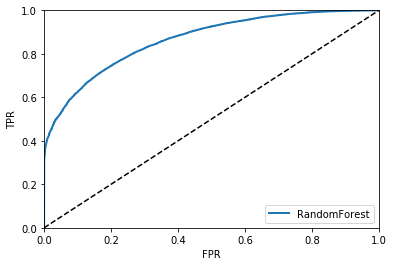

In [35]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, pred)

plot_roc_curve(fpr_forest, tpr_forest, label='RandomForest')
plt.legend(loc="lower right")
plt.show()

## 학습모델 저장

In [40]:
joblib.dump(rand_clf_tuned, 'rand_forest_model.pkl')

['rand_forest_model.pkl']

In [41]:
clf_from_joblib = joblib.load('rand_forest_model.pkl') 
pred = clf_from_joblib.predict(x_test)
accuracy_score(pred, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished


0.7778499091145157